In [43]:
mdganoutpath=r'D:\SP2\mdgan_output'
import sys
if sys.platform=='linux':
    mdganoutpath = '/media/songbird/Data/mdgan_output'
import numpy as np
import os
from datetime import datetime
import pickle
import pandas as pd
from IPython.display import display, HTML
from utils import play_clip
from utils import play_file

In [44]:
def sorted_ls(path):
    mtime = lambda f: os.stat(os.path.join(path, f)).st_mtime
    return list(sorted(os.listdir(path), key=mtime))

In [45]:
path = os.path.join(mdganoutpath,sorted_ls(mdganoutpath)[-1])
loss_path = os.path.join(path,'losses')
hist_path = os.path.join(path,'hist')
params = os.path.join(path,'params.')
opts = []
for folder in os.listdir(mdganoutpath):
    if len(os.listdir(os.path.join(mdganoutpath,folder)))>20:
        try:
            with open(os.path.join(mdganoutpath,folder,'opt.pkl'),'rb') as f:
                opts.append(pickle.load(f))
        except:
            pass
try:
    with open(os.path.join(path,'opt.pkl'),'rb') as f:
        opt = pickle.load(f)
except:
    print("No options file found")

def parse_param(param,opts):
    out = [vars(i)[param] if param in vars(i).keys() else None for i in opts]
    if param=='outf':
        out = [i.split('/')[-1].replace('mdgan_output','') for i in out]
    return np.array(out)
    
params = ['nz','ngf','ndf','lambdaa','d_noise','batchSize','outf']
df = pd.DataFrame()
for p in params:
    df[p] = parse_param(p,opts)
    
HTML(df.to_html())

In [86]:
#Use to select from table
select = 59
if select:
    path = os.path.join(mdganoutpath,df.outf.values[select])
    with open(os.path.join(path,'opt.pkl'),'rb') as f:
        opt = pickle.load(f)
print("Current directory: ",path)
print(opt)


Current directory:  /media/songbird/Data/mdgan_output/2017-11-13 13-56-24.027163
Namespace(batchSize=128, beta1=0.5, cuda=True, d_noise=0.1, dataroot='/media/songbird/Data/deep_learn_data/mdgan_input_16k_256pt_byday_transformed', dataset='folder', distance_fun='L2', imageH=129, imageSize=32, imageW=16, lambdaa=100.0, log_every=200, lr=0.0002, nc=1, ndf=128, netD1='', netD2='', netD3='', netE='', netG='', ngf=128, ngpu=1, niter=25, nz=128, outf='/media/songbird/Data/mdgan_output/2017-11-13 13-56-24.027163', sample_rate=16000.0, workers=5)


In [87]:
from os.path import join
files = os.listdir(join(path,"validation"))
val = pd.read_csv(join(path,"validation","validation.csv"))
val_mean = val['validation_mean'].values
lowest = np.argmin(val_mean)
val_std = val['validation_std'].values[lowest]
print("Lowest validation mean on epoch: %d"%(lowest))
print(min(val_mean))
print(val_std)
print(opt.nz)

Lowest validation mean on epoch: 2
0.0087
0.0018
128


In [8]:
def ma(a, n=3):
    #moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


<IPython.core.display.Javascript object>


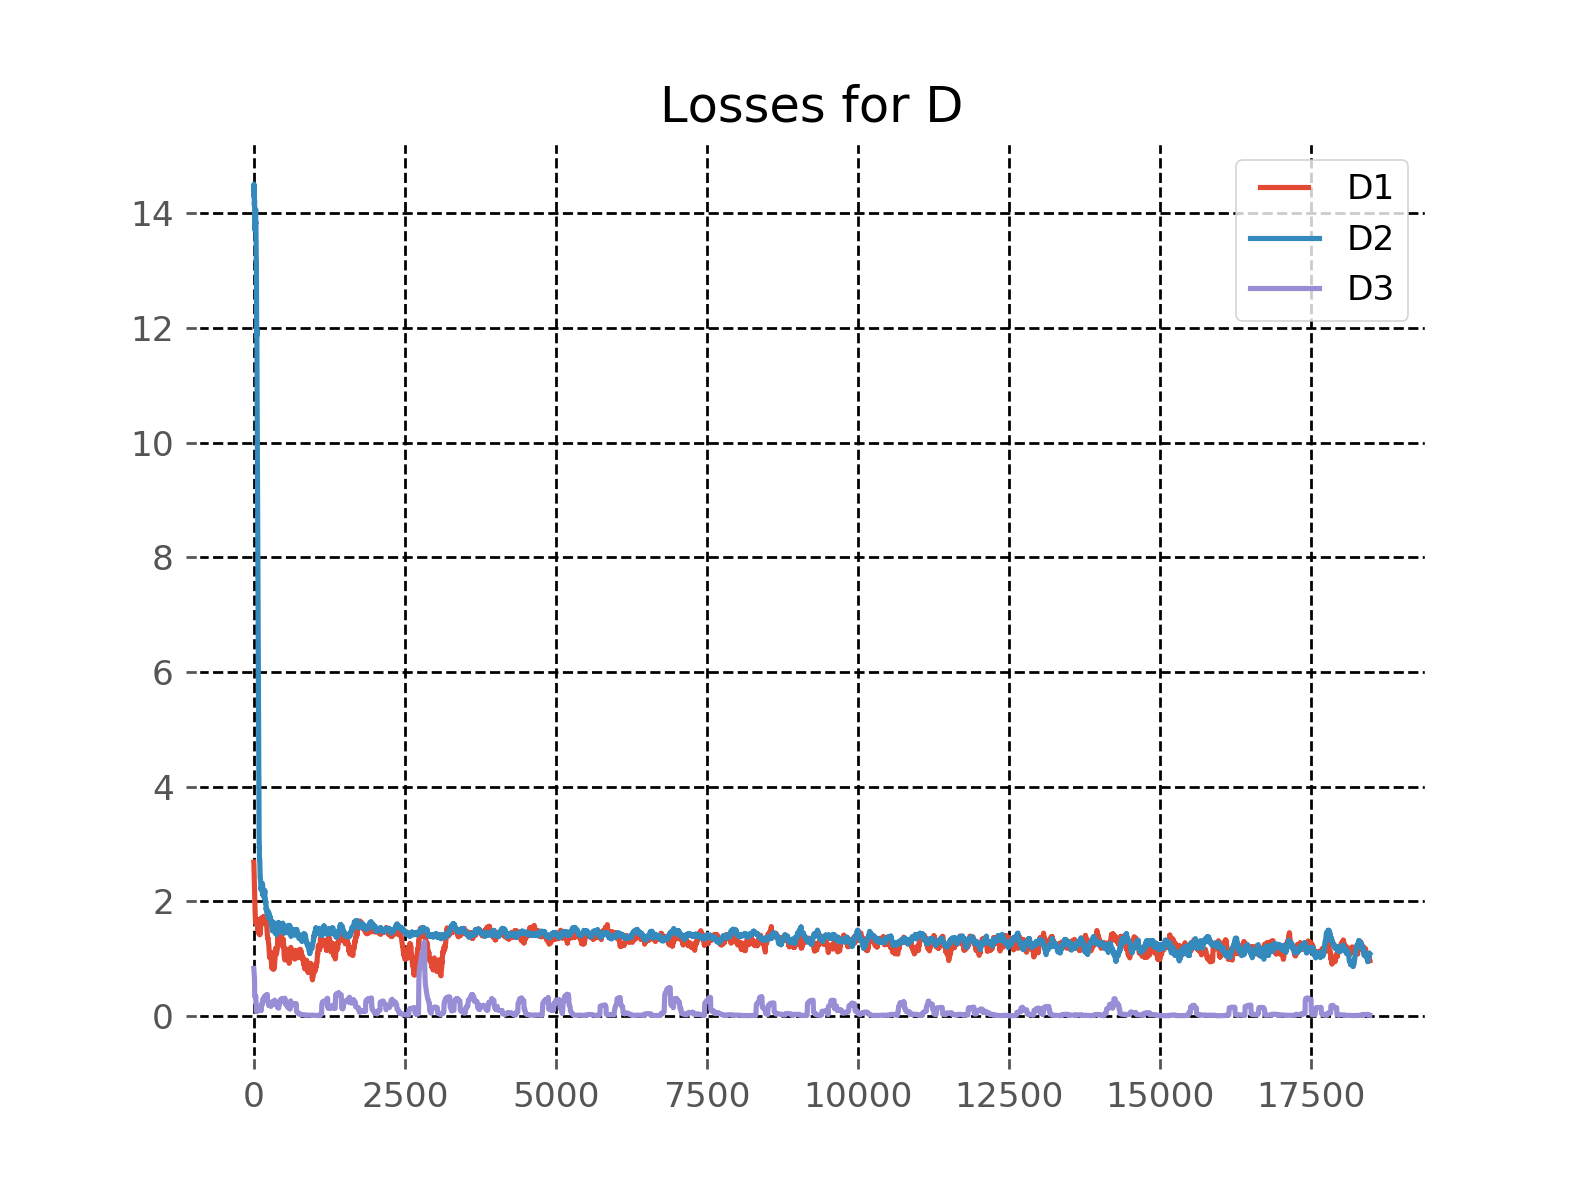

<IPython.core.display.Javascript object>


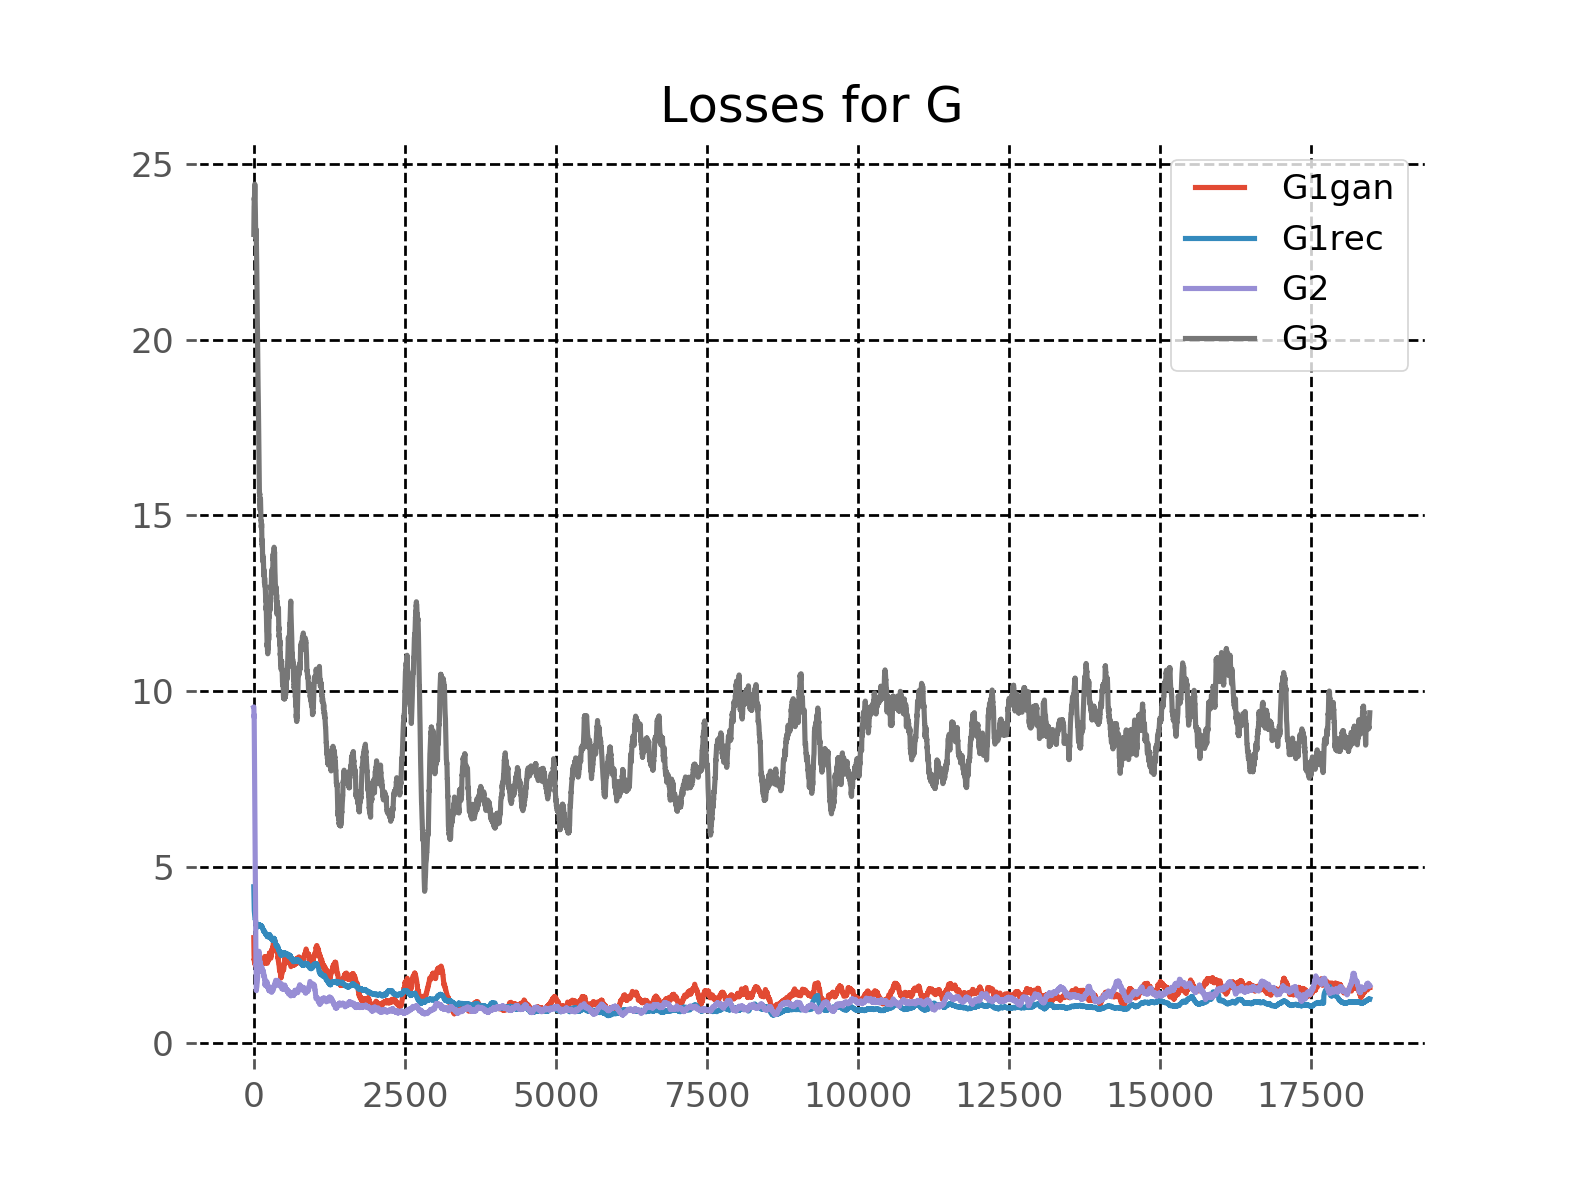

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.legend_handler import HandlerNpoints
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('grid', linestyle="--", color='black')

n_ma = 100
files = os.listdir(loss_path)
data = [np.load(os.path.join(loss_path,f)) for f in files]
x = np.arange(0,len(data[0]))

def interactive_plot(data,files,GorD):
    plt.figure()
    plots=[]
    for i in range(len(data)):
        if GorD not in files[i]:
            continue
        p, = plt.plot(ma(data[i],n=n_ma),label=files[i].replace('.npy',''))
        plots.append(p)
    plt.legend(handler_map={plots[0]: HandlerLine2D(numpoints=4)})
    plt.title('Losses for '+GorD)

interactive_plot(data,files,'D')
interactive_plot(data,files,'G')


<IPython.core.display.Javascript object>


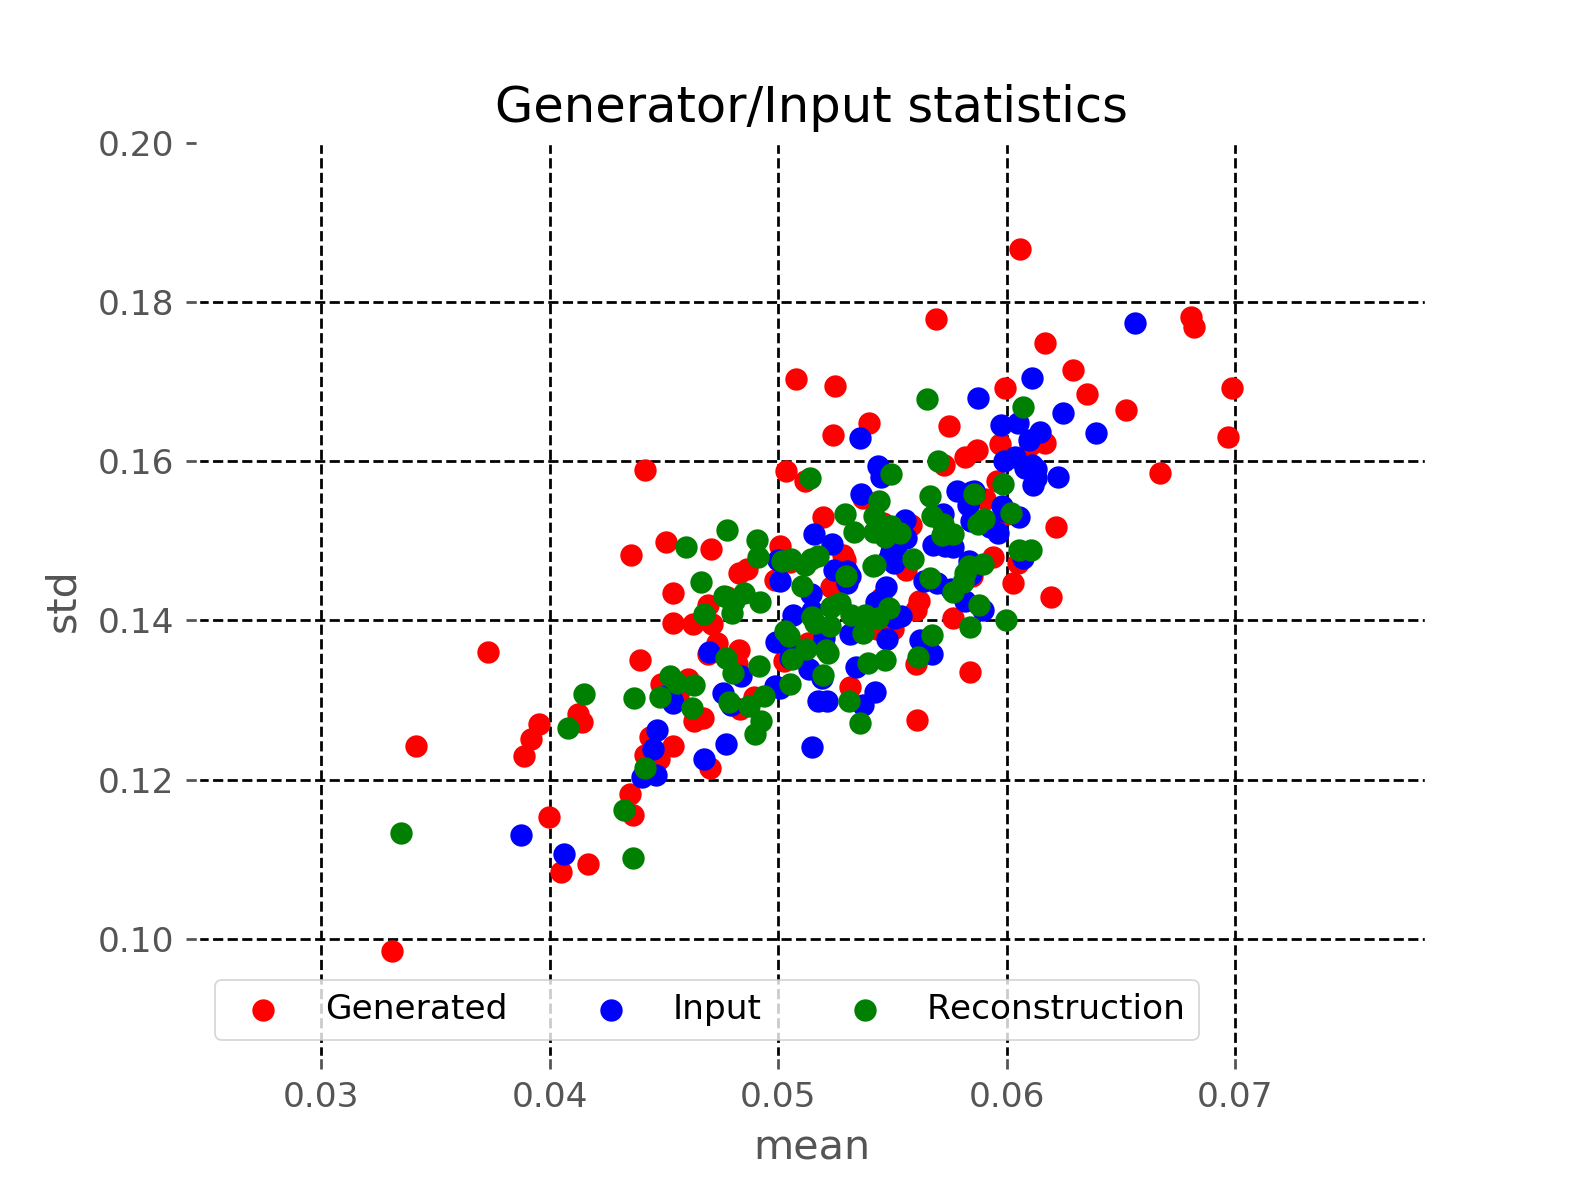

<IPython.core.display.Javascript object>


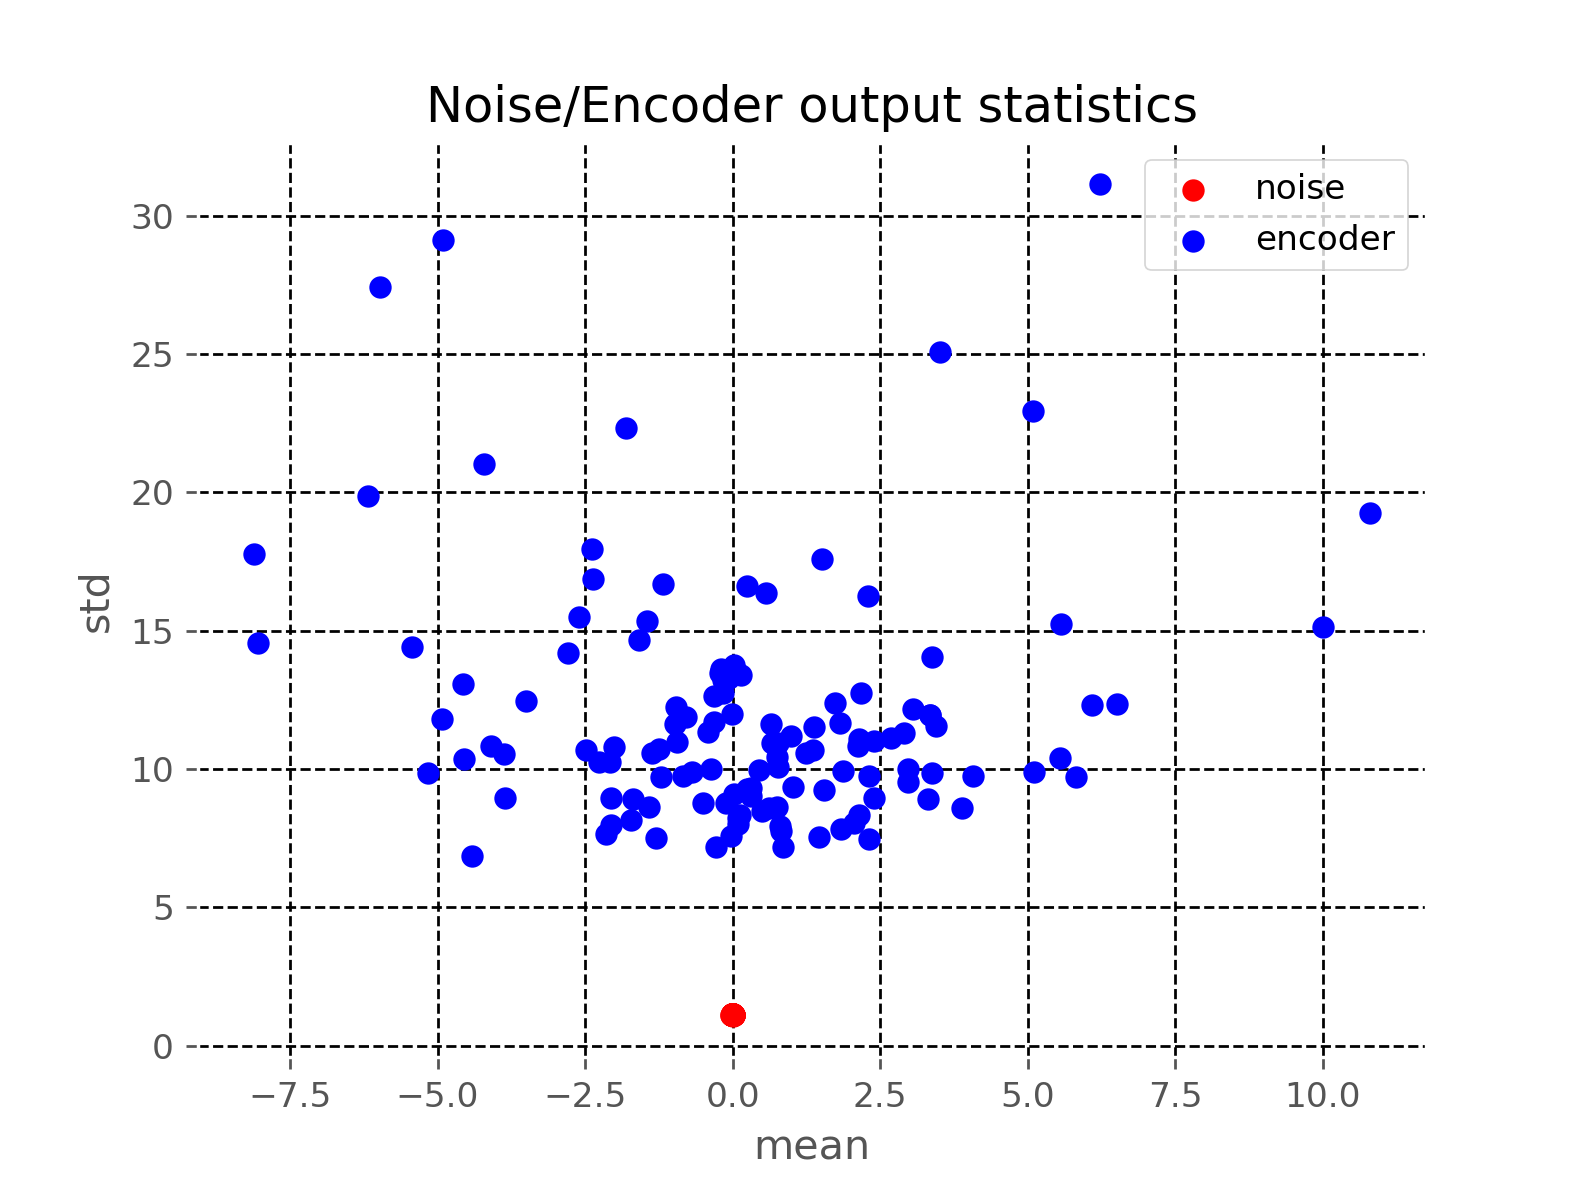

<IPython.core.display.Javascript object>


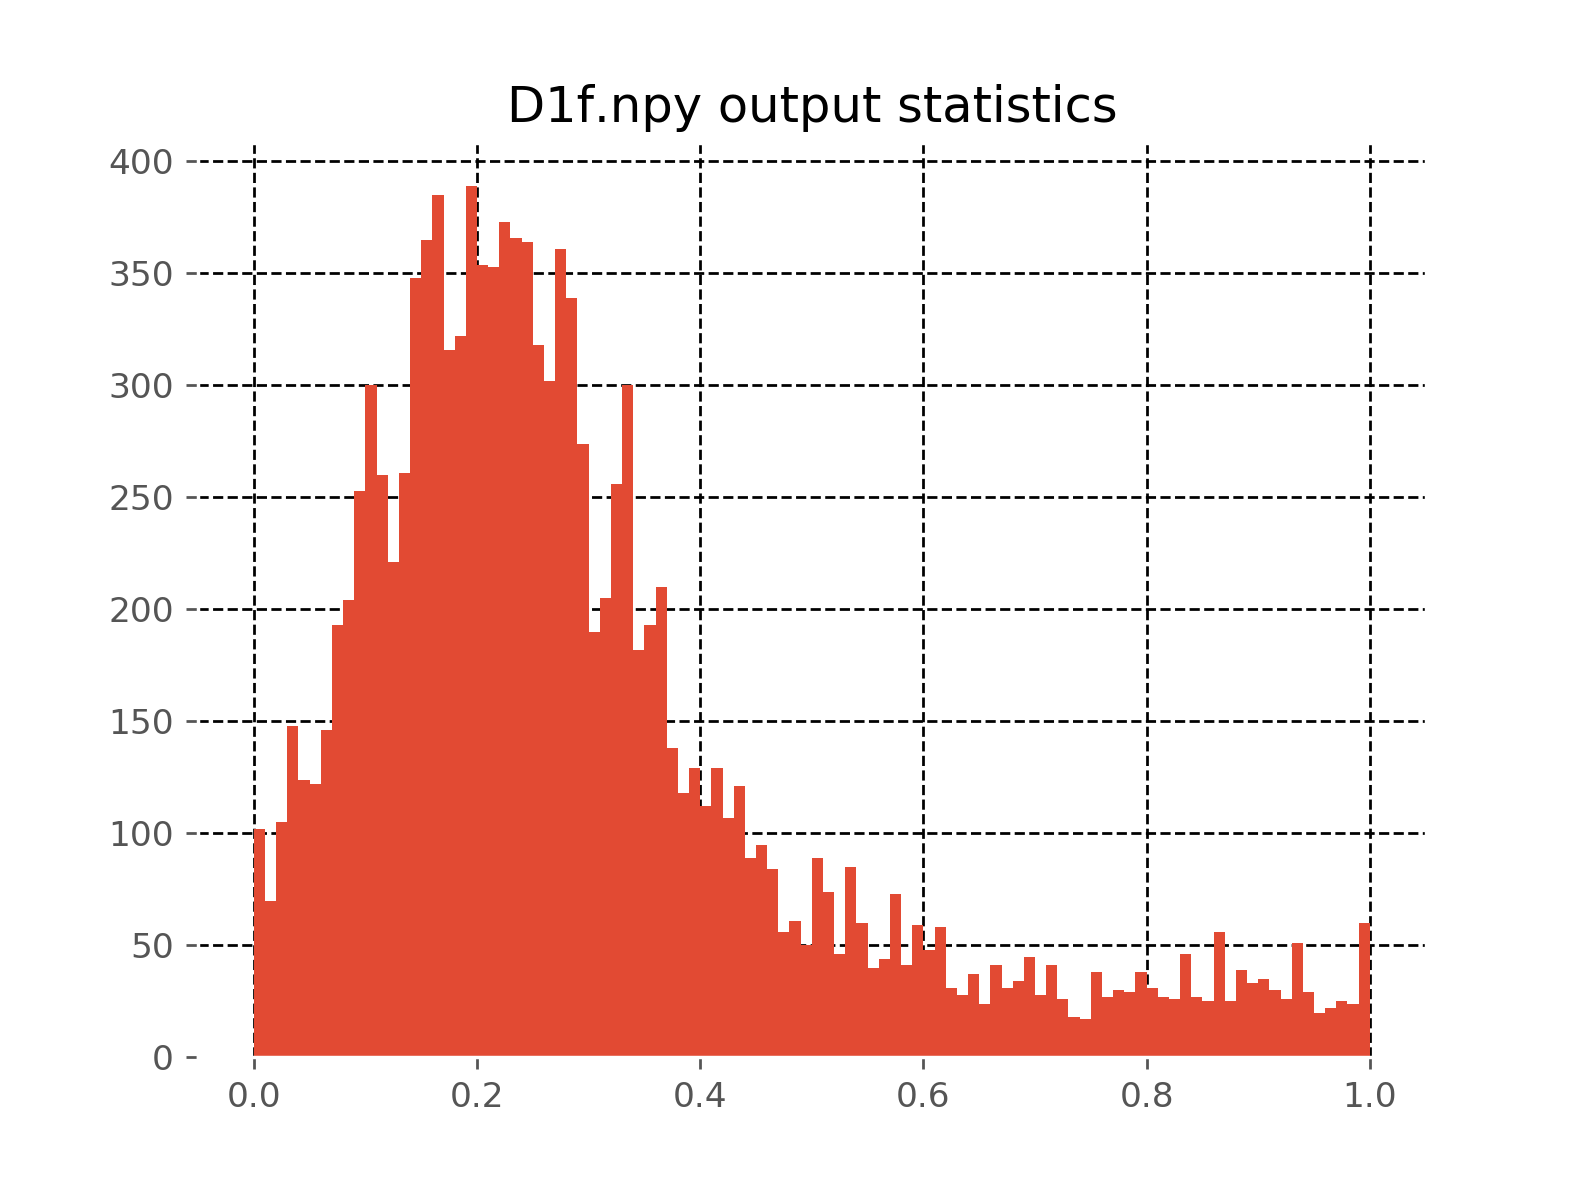

<IPython.core.display.Javascript object>


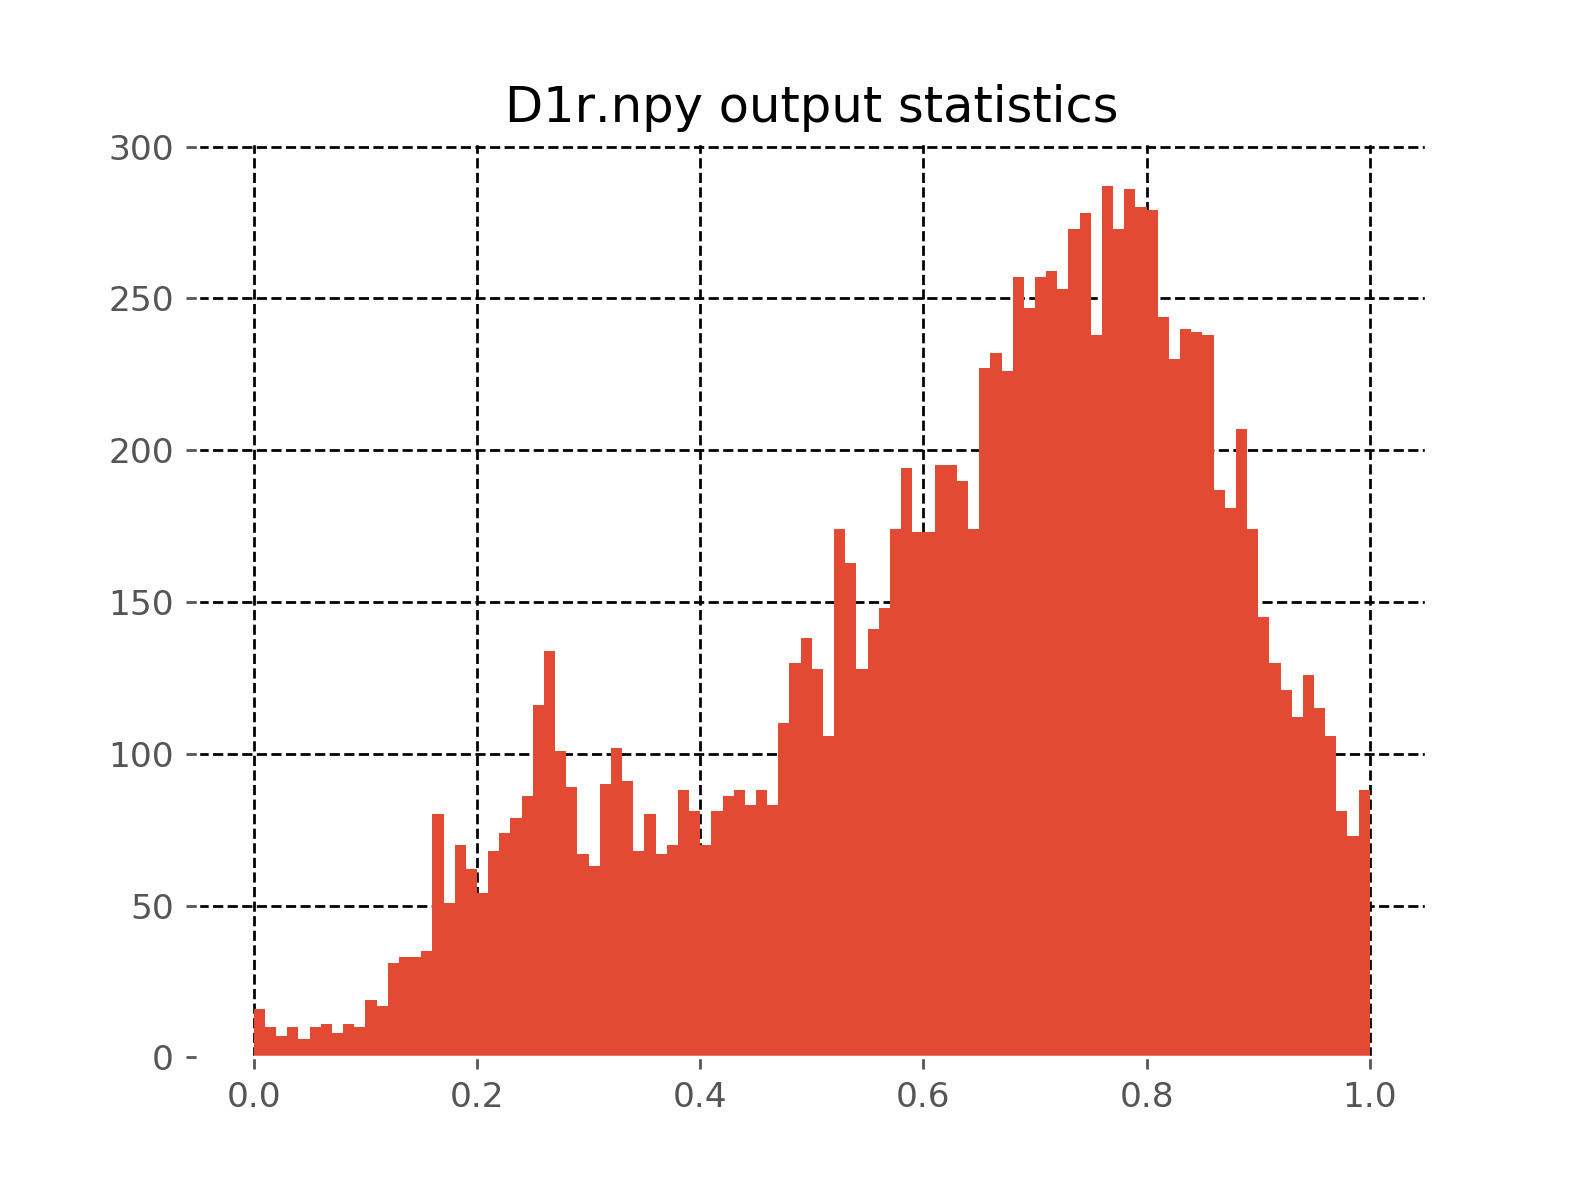

<IPython.core.display.Javascript object>


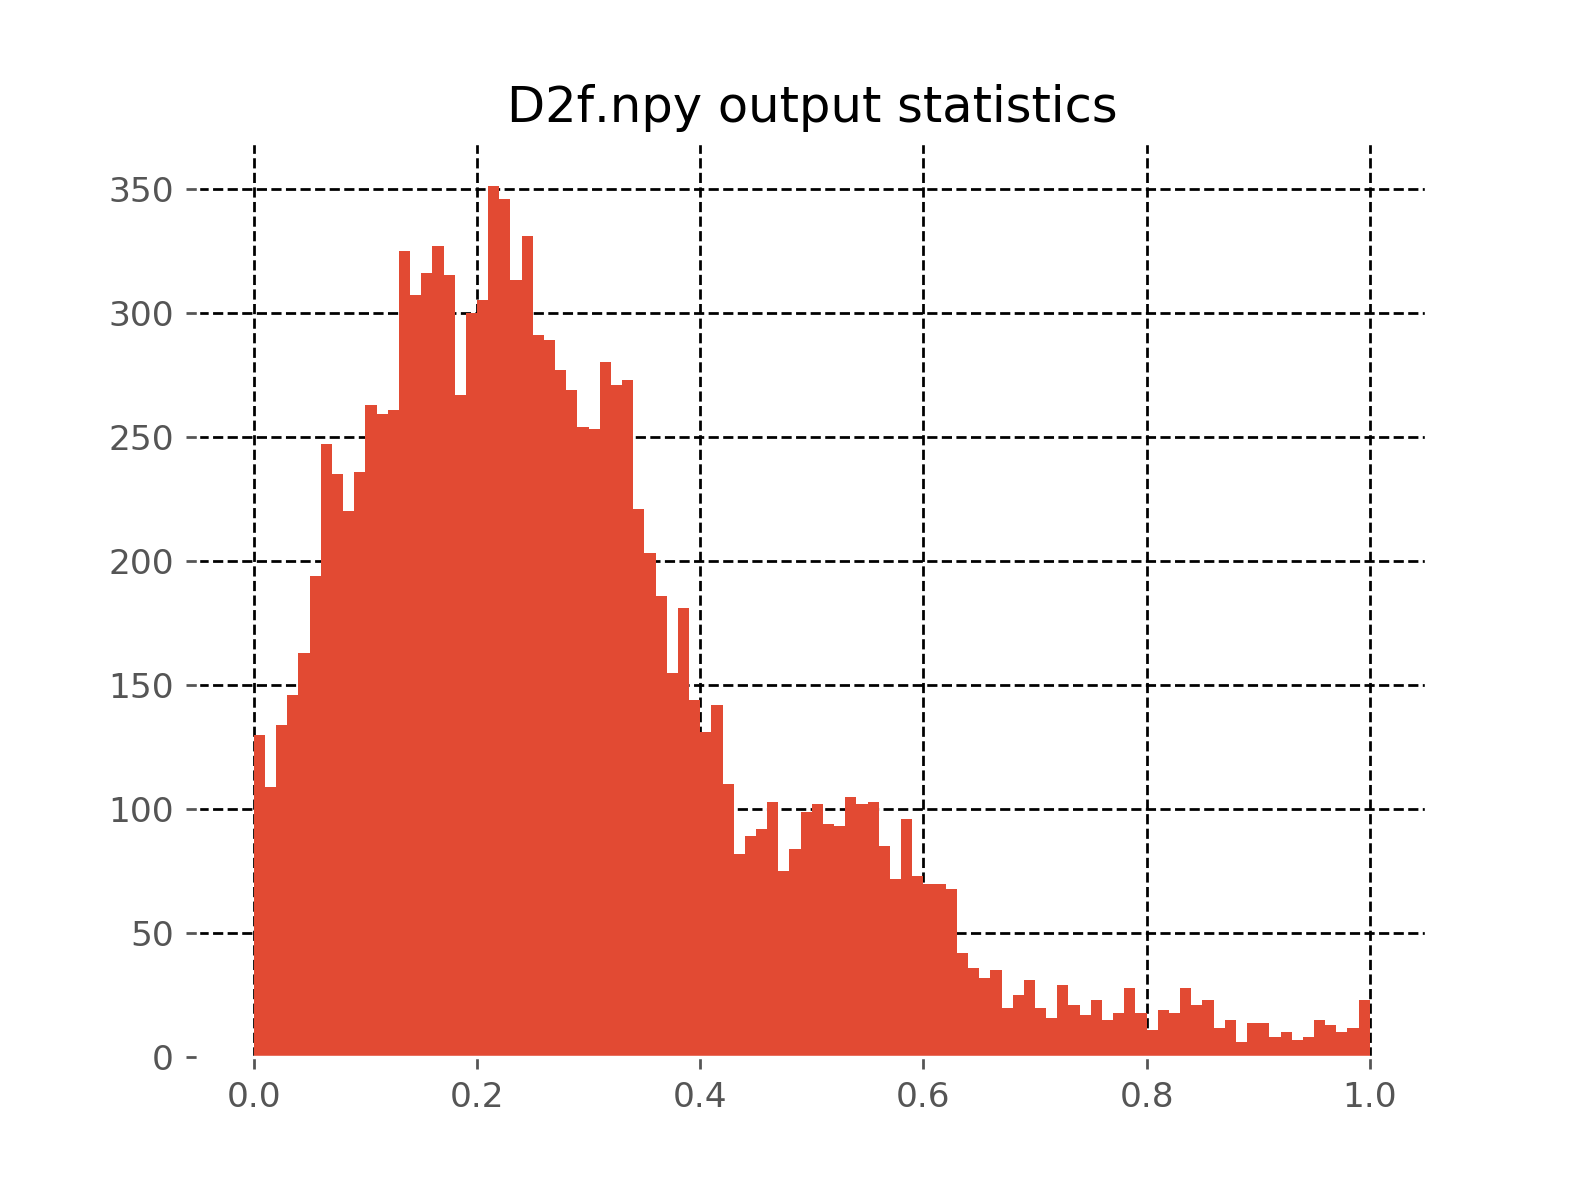

<IPython.core.display.Javascript object>


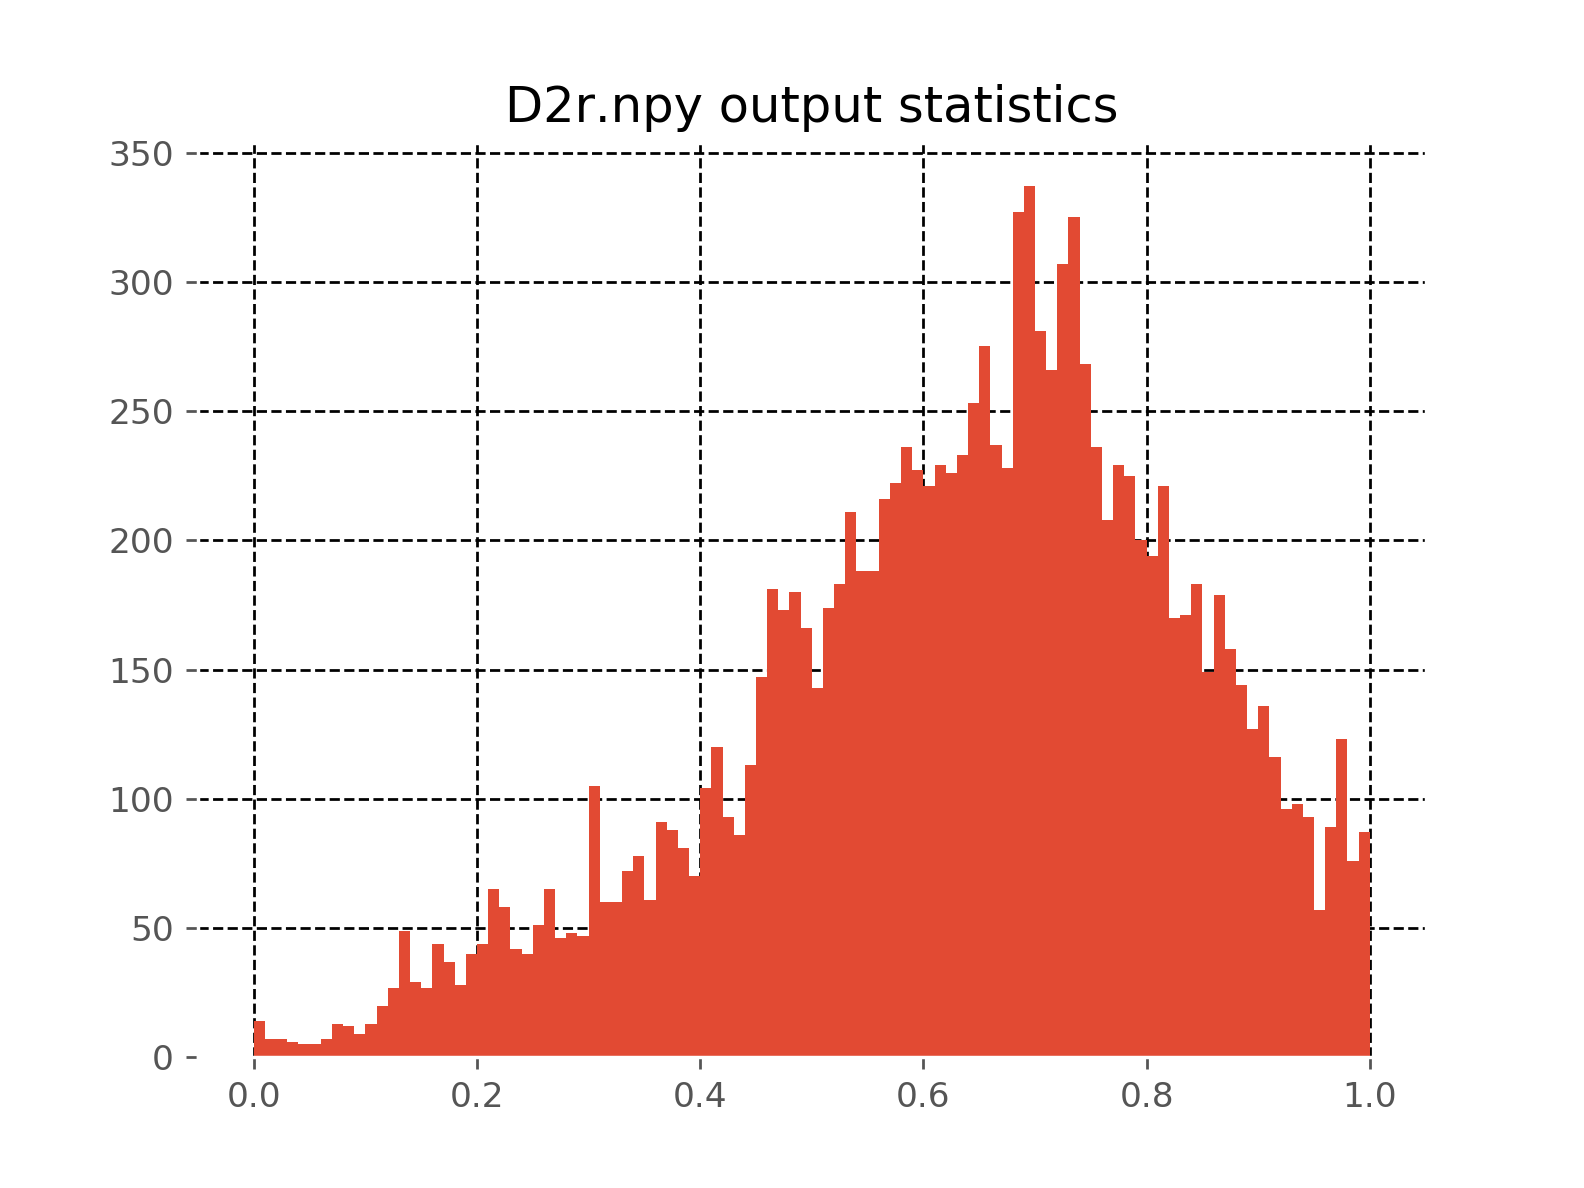

<IPython.core.display.Javascript object>


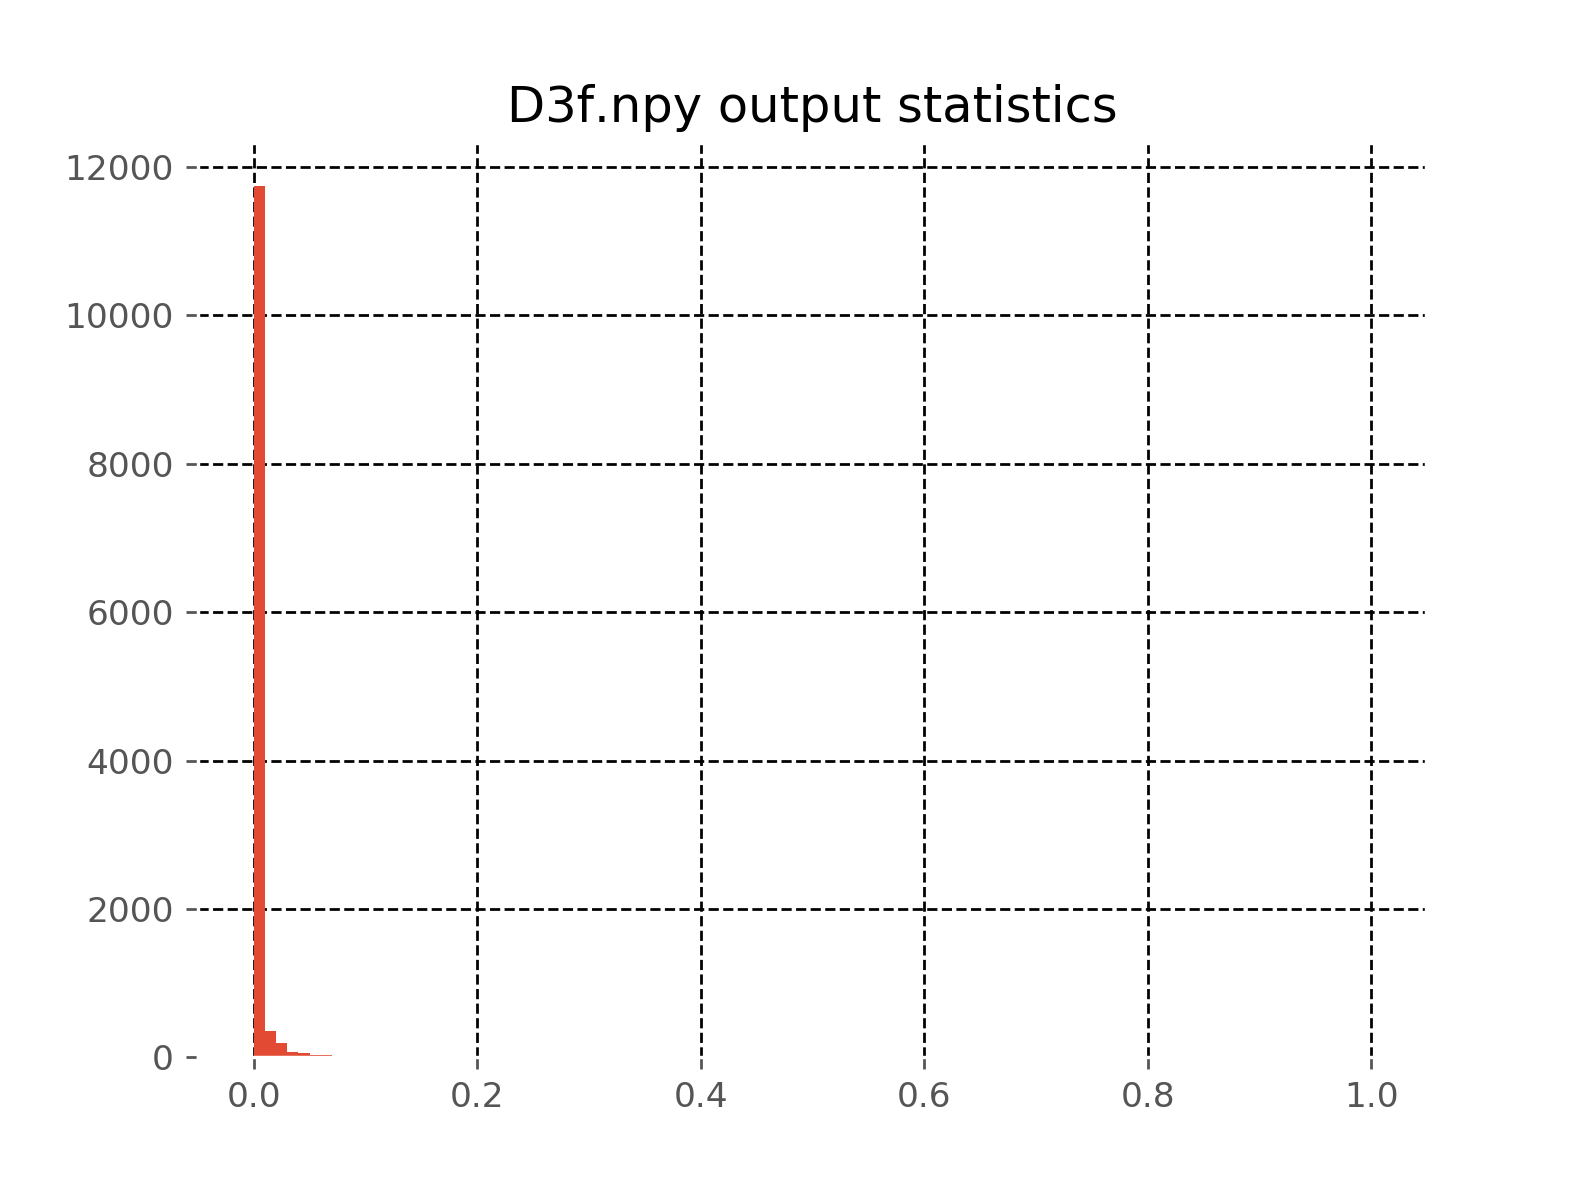

<IPython.core.display.Javascript object>


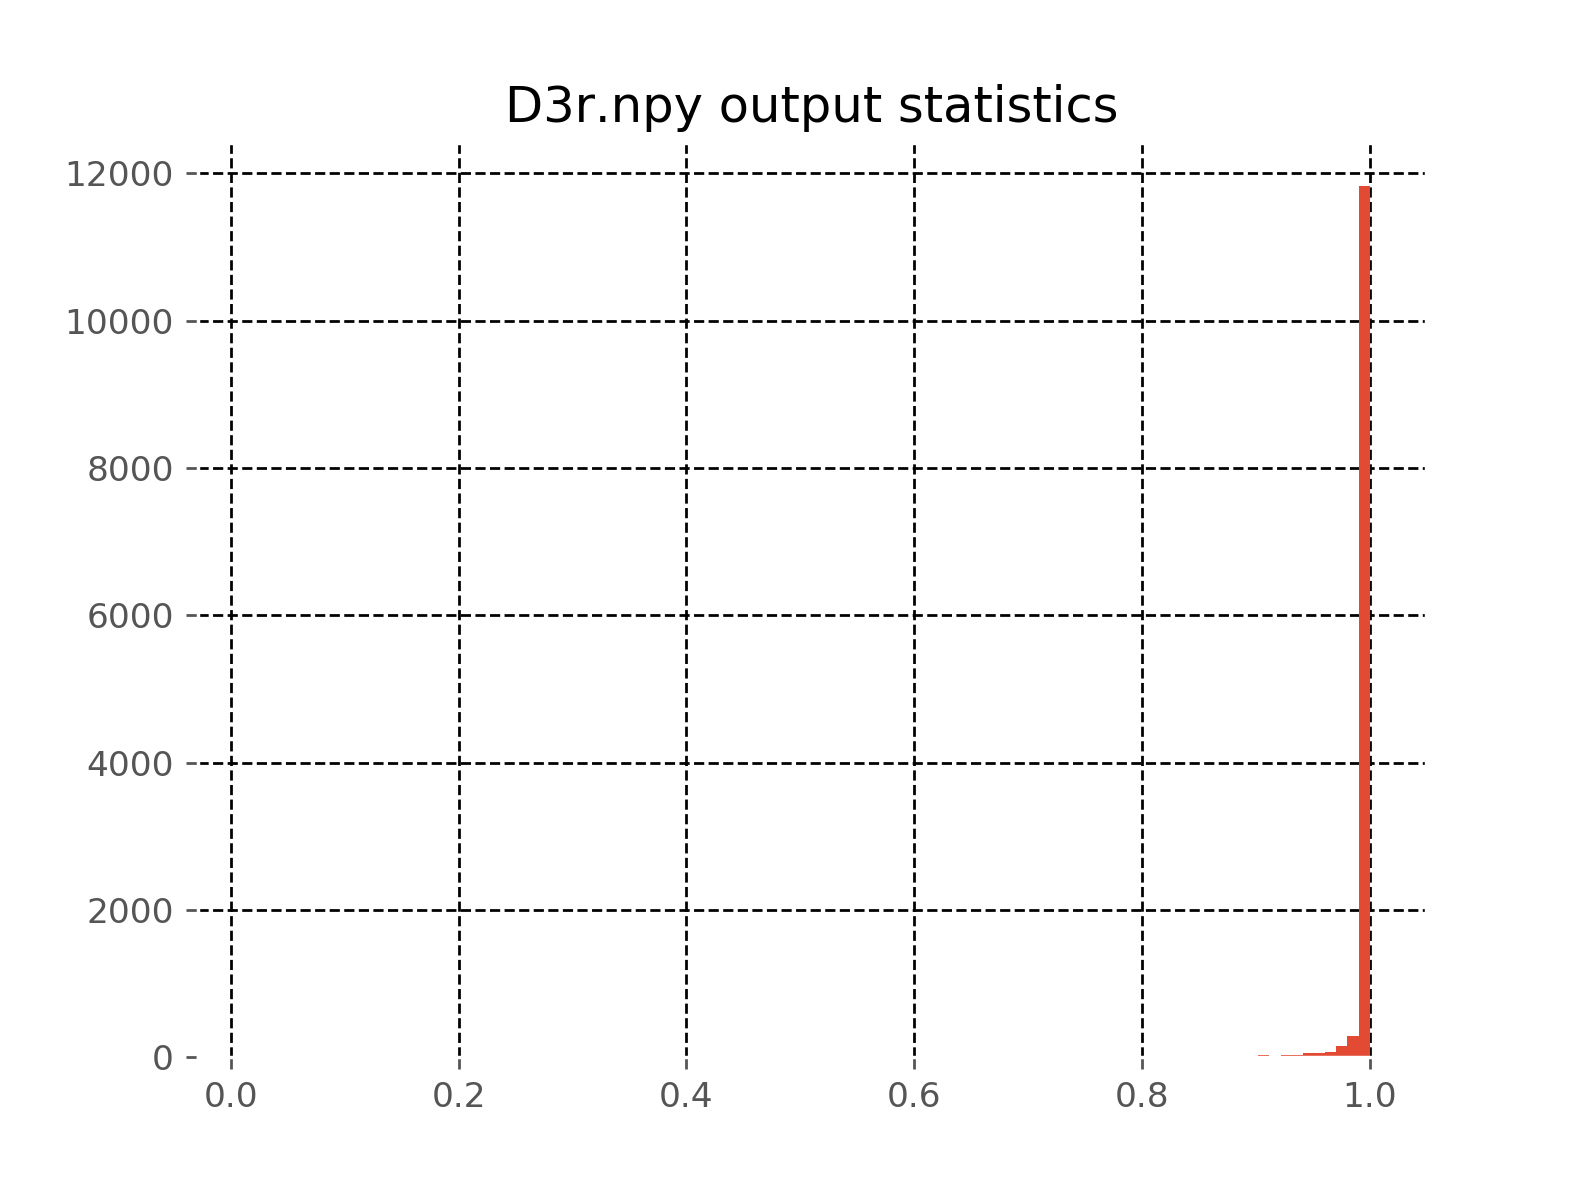

In [10]:
files = os.listdir(hist_path)
data = [np.load(os.path.join(hist_path,f)) for f in files]
history = 100
gmeans = data[files.index('Gmeans.npy')][-history:]
gstds = data[files.index('Gstds.npy')][-history:]
imeans = data[files.index('inputmeans.npy')][-history:]
istds = data[files.index('inputstds.npy')][-history:]
rmeans = data[files.index('recmeans.npy')][-history:]
rstds = data[files.index('recstds.npy')][-history:]
plots=[]
plt.figure()
plots.append(plt.scatter(gmeans,gstds,c='r'))
plots.append(plt.scatter(imeans,istds,c='b'))
plots.append(plt.scatter(rmeans,rstds,c='g'))

plt.legend(tuple(plots),
           tuple(['Generated','Input','Reconstruction']),
           scatterpoints=1,
           loc='lower left',
           ncol=3)
plt.xlabel('mean')
plt.ylabel('std')
plt.title('Generator/Input statistics')

e = data[files.index('E.npy')].reshape(data[files.index('E.npy')].shape[:3])[-history:]
shape = e[0].shape
e = np.array([i for i in e if i.shape==shape])
e = e.reshape([e.shape[1]*e.shape[0],e.shape[2]])
emeans = e.mean(axis=0)
estd = e.std(axis=0)

n = data[files.index('noise.npy')].reshape(data[files.index('noise.npy')].shape[:3])[-history:]
shape = n[0].shape
n = np.array([i for i in n if i.shape==shape])
n = n.reshape([n.shape[1]*n.shape[0],n.shape[2]])
n_means = n.mean(axis=0)
n_std = n.std(axis=0)
plots=[]
plt.figure()
plots.append(plt.scatter(n_means,n_std,c='r'))
plots.append(plt.scatter(emeans,estd,c='b'))
plt.xlabel('mean')
plt.ylabel('std')
plt.legend(tuple(plots),tuple(['noise','encoder']))
plt.title('Noise/Encoder output statistics')

files_d = [i for i in files if 'D' in i]
bins = np.arange(0,1,0.01)
for i in range(len(files_d)):
    plt.figure()
    d = data[files.index(files_d[i])].reshape(data[files.index(files_d[i])].shape[:2])[-history:]
    shape = d[0].shape
    d = np.array([i for i in d if i.shape==shape])
    d = d.flatten()
    h=plt.hist(d,100,label=files_d[i].replace('r',' real').replace('f',' fake'))
    plt.title(files_d[i]+ ' output statistics')



In [17]:
from IPython.display import Image
files = sorted_ls(path)
epoch = 1
figs = [i for i in files if '.png' in i]
audio = [i for i in files if '.wav' in i]

if epoch is not None:
    if epoch<10:
        num = '00'+str(epoch)
    elif epoch<100:
        num = '0'+str(epoch)
    figs = [i for i in figs if 'epoch_'+num in i]
    if len(audio)>0:
        audio = [i for i in audio if 'epoch_'+num in i]

latest_fake = [i for i in figs[-3:] if 'fake' in i][0]
latest_rec = [i for i in figs[-3:] if 'rec' in i][0]

if len(audio)>0:
    audio_latest_input = [i for i in audio[-2:] if 'input' in i][0]
    audio_latest_rec = [i for i in audio[-2:] if 'rec' in i][0]

print("Latest epoch: ",latest_fake.split('_')[-3])

Latest epoch:  001


In [63]:
play_file(os.path.join(path,audio_latest_input))

RuntimeError: Error opening '/media/songbird/Data1/mdgan_output/2017-10-06 16-11-51.456787/input_audio_epoch_005_batchnumb_2200.wav': System error.

In [52]:
play_file(os.path.join(path,audio_latest_rec))

playing from file:  D:\SP2\mdgan_output\2017-10-19 18-03-55.276474\rec_audio_epoch_014_batchnumb_50.wav


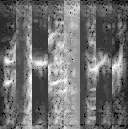

In [18]:
Image(filename=os.path.join(path,latest_fake),width=500) 

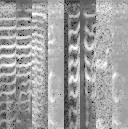

In [19]:
Image(filename=os.path.join(path,latest_rec),width=500) 

## Look at validation results
Use validate_models.py script to validate models

In [76]:
from os.path import join
files = os.listdir(join(path,"validation"))
val = pd.read_csv(join(path,"validation","validation.csv"))
val_mean = val['validation_mean'].values
lowest = np.argmin(val_mean)
val_std = val['validation_std'].values[lowest]
print("Lowest validation mean on epoch: %d"%(lowest))
print(min(val_mean))
print(val_std)
print(opt.nz)

Lowest validation mean on epoch: 1
0.0162
0.0036
32
